In [182]:
#standard imports
import detprocess as dp
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import qetpy as qp

from pytesdaq.io.hdf5 import H5Reader, getrandevents

from scipy import stats, optimize

from matplotlib import rc
rc('text', usetex=False)
rc('font', family="sans-serif")
rc('axes', labelsize=12)
rc('font', size=12)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

In [183]:
run = 18
#series = '20211001_0847'
#version = 5
#suffix = ''

trigger_path = '/data/users/da_real_maggie_reed/processed/run18/trigger_I2_D20220629_T143829/'
yaml_path = '/data/users/da_real_maggie_reed/analysis/run_18/data/process_run18_fromrun10.yaml'
save_path = '/data/users/da_real_maggie_reed/processed/run18/deptprocess_I2_D20220628_T210658'
if not Path(save_path).is_dir():
    raise OSError(f"Please create {save_path} for saving processed files.")
series = [Path(s).parts[-1] for s in sorted(glob(f"{trigger_path}*"))]

In [34]:
#process over our data
for ii, file in enumerate(sorted(glob(f"{trigger_path}/*.hdf5"))):
    df = dp.process_data(
        file,
        yaml_path,
        savepath=save_path, # pass None if you don't want to save the file (for debugging)
        #nevents=10, # process only the first 10 events (for debugging)
        #external_file=None, # set to the path to an external file that contains different features than the default (see the README for more info)
    )
    print(ii)

0
1
2
3
ERROR: unable to open file /data/users/da_real_maggie_reed/processed/run18/trigger6sigma_I2_D20220630_T132125/rand_I2_D20220630_T132231_F0005.hdf5


TypeError: 'NoneType' object is not subscriptable

In [184]:
#loads all the features we got from the hdf5 made by dp
#returns a dataframe
#files are already created and ready to go from a prior build
df = dp.io.load_features(save_path)

In [185]:
df.keys()

Index(['ofamp_nodelay_CPDv21Ge', 'ofchi2_nodelay_CPDv21Ge',
       'ofamp_unconstrained_CPDv21Ge', 'oft0_unconstrained_CPDv21Ge',
       'ofchi2_unconstrained_CPDv21Ge', 'ofamp_constrained_CPDv21Ge',
       'oft0_constrained_CPDv21Ge', 'ofchi2_constrained_CPDv21Ge',
       'baseline_CPDv21Ge', 'integral_CPDv21Ge', 'energyabsorbed_CPDv21Ge',
       'eventnumber', 'eventindex', 'dumpnumber', 'seriesnumber', 'eventtime',
       'triggertype', 'triggeramp', 'triggertime'],
      dtype='object')

In [186]:
#setting the channel trigger type to continuous
#1=continuous, 2=ext trigger, 3=randoms, 4=threshold
ctrigger = df.triggertype == 1

In [207]:
ctime = df.eventtime < 90500+1.6564e9

In [264]:
cbaseline = dp.inrange(df.baseline_CPDv21Ge, -4e-6,-3.13e-6, include_lwrbnd=True, include_uprbnd=True)
cchi2 = dp.inrange(df.ofchi2_nodelay_CPDv21Ge, 0.5e-14, 0.645e-14, include_lwrbnd=True, include_uprbnd=True)
cmask = ctrigger & ctime & cbaseline & cchi2

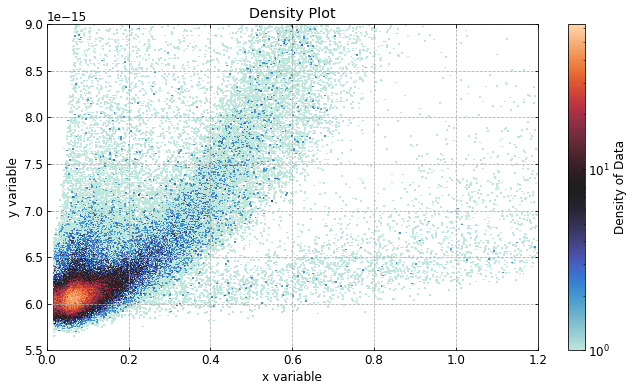

In [289]:
#checking the fit of our amplitudes v chi2
#a "good" fit against chi2 will be about ~ number of bins
fig, ax = dp.densityplot(
    df.ofamp_unconstrained_CPDv21Ge*1e6,
    df.ofchi2_unconstrained_CPDv21Ge,
    cut=ctrigger&ctime,
    ylims=[0.55e-14, 0.9e-14],
    xlims=[0, 1.2],
)
"""
ax.axvline(x=1.2e-7,ymin=0.8e-14,ymax=1)
ax.axvline(x=0.2e-7,ymin=0.8e-14,ymax=1)
ax.axhline(y=0.635e-14, xmin=0, xmax=1)
ax.axhline(y=0.58e-14, xmin=0, xmax=1)
ax.axhline(y=0.68e-14, xmin=0, xmax=1)
ax.axhline(y=0.728e-14, xmin=0, xmax=1)
""";

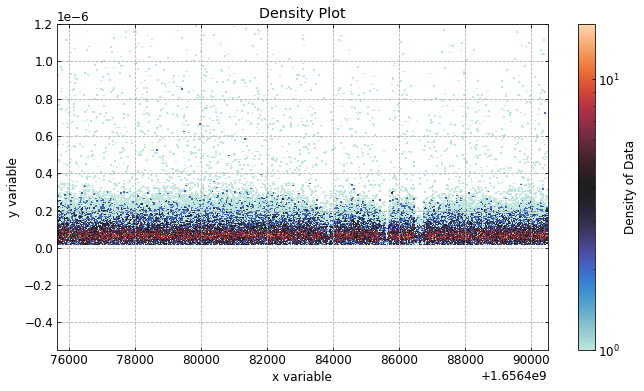

In [275]:
fig, ax = dp.densityplot(
    df.eventtime,
    df.ofamp_unconstrained_CPDv21Ge,
    cut=cmask,
    ylims=[-0.55e-6, 1.2e-6],
   # xlims=[0.0e-5, 6e-7],
)

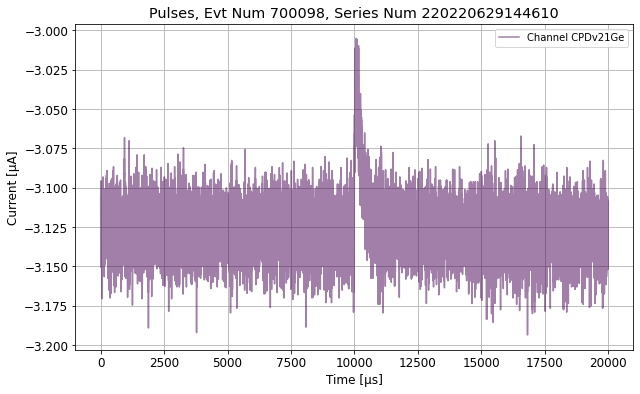

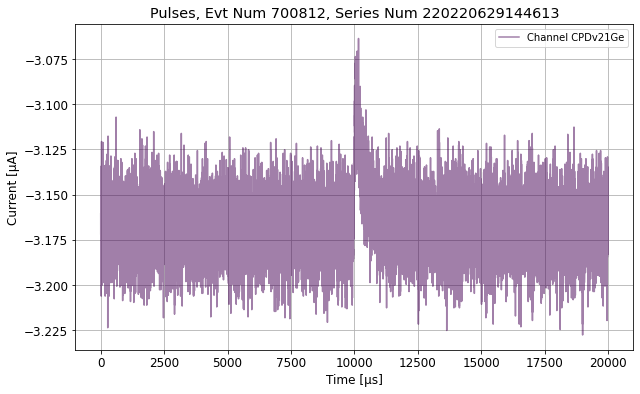

In [137]:
check_cut_lower = (dp.inrange(df.ofamp_unconstrained_CPDv21Ge, 0.2e-7, 1.2e-7)
                   & 
                   dp.inrange(df.ofchi2_unconstrained_CPDv21Ge, 0.58e-14, 0.635e-14)
                  )
lower_rands = getrandevents(trigger_path,
    df.eventnumber,
    df.seriesnumber,
    ntraces=20,
    nplot=1,
    channels=['CPDv21Ge'],
    cut=ctrigger & check_cut_lower,
    lgcplot=True)
check_cut_upper = (dp.inrange(df.ofamp_unconstrained_CPDv21Ge, 0.2e-7, 1.2e-7)
                   & 
                   dp.inrange(df.ofchi2_unconstrained_CPDv21Ge, 0.68e-14, 0.728e-14)
                  )
upper_rands = getrandevents(trigger_path,
    df.eventnumber,
    df.seriesnumber,
    ntraces=20,
    nplot=1,
    channels=['CPDv21Ge'],
    cut=ctrigger & check_cut_upper,
    lgcplot=True)

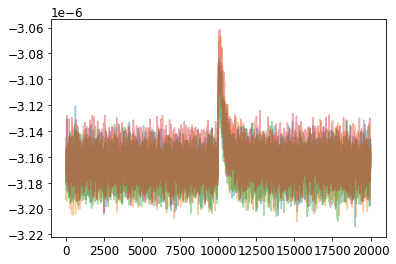

In [155]:
t = upper_rands[0]
x = upper_rands[1]
cout_upper = upper_rands[2]
lowpassed_upper = qp.utils.lowpassfilter(x, cut_off_freq=1e5)

for xx in lowpassed_upper[:4,0]:
    plt.plot(t*1e6, xx, alpha=0.4)
# plt.xlim(9500, 11000)
#dp.scatter(t, lowpassed_upper)
#np.ndim(x)
#upper_rands
t1 = lower_rands[0]
x1 = lower_rands[1]
cout_lower = lower_rands[2]
lowpassed_lower = qp.utils.lowpassfilter(x1)

# plt.plot(t1*1e6, lowpassed_lower[5,0])
#plt.xlim(9500, 12500)

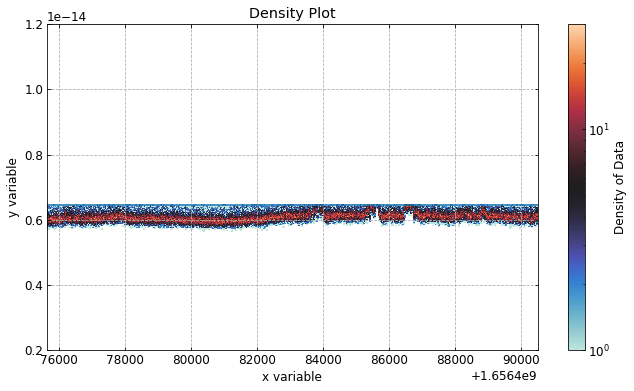

In [263]:
fig, ax = dp.densityplot(
    df.eventtime,
    df.ofchi2_nodelay_CPDv21Ge,
    cut=ctrigger & ctime & cchi2,
    ylims=[0.2e-14, 1.2e-14]
  #  xlims=[0.0e-5, 6e-7],
)
#ax.axvline(x=90500+1.6564e9,ymin=0.2e-14,ymax=1)
#cut all events past time 
ax.axhline(y=0.645e-14, xmin=0, xmax=1)
#cut all events past this chi2 


In [134]:
(df.ofamp_nodelay_CPDv21Ge[cout_upper], 
 df.ofamp_nodelay_CPDv21Ge[cout_lower])

(113    7.857655e-08
 Name: ofamp_nodelay_CPDv21Ge, dtype: float64,
 657    9.839842e-08
 Name: ofamp_nodelay_CPDv21Ge, dtype: float64)

In [280]:
tot_runtime = df.eventtime[ctrigger].iloc[-1]-df.eventtime[ctrigger].iloc[0]
#rate of the events at weird pulse in Hz
sum(check_cut_lower)/tot_runtime


3.244954598186177

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Histogram'}, xlabel='variable', ylabel='Count'>)

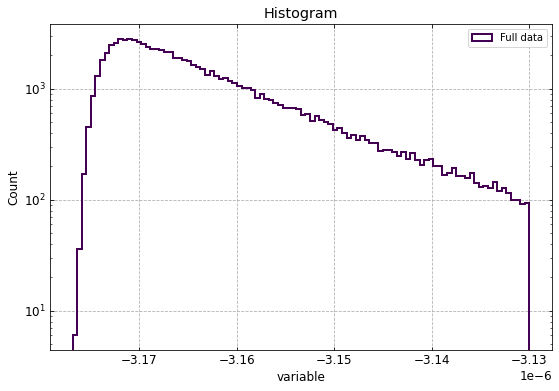

In [270]:
#checking the baseline distribution
dp.hist(
    df.baseline_CPDv21Ge[cmask],
    nbins=100,
)

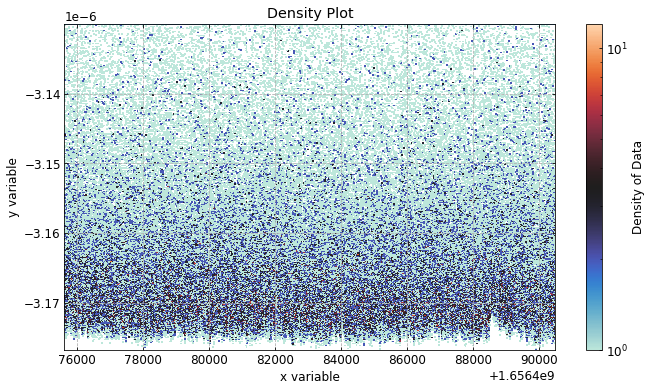

In [254]:
fig, ax = dp.densityplot(
    df.eventtime,
    df.baseline_CPDv21Ge,
    cut=ctrigger & ctime & cbaseline,
  #  ylims=[-3.5e-6, -2.5e-6]
  #  xlims=[0.0e-5, 6e-7],
)

ax.axhline(y=-3.13e-6, xmin=0, xmax=1)
#choose baseline cut here

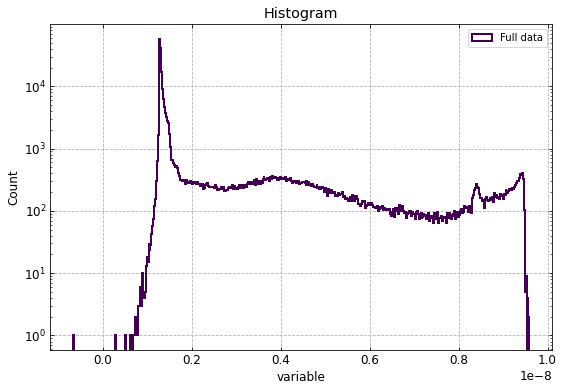

In [278]:
#integral of an event without baseline subtraction
#remove the baseline to avoid including an elevated or negative baseline
#make sure baseline is scaled the same as pulse integral
fig, ax = dp.hist(
    df.integral_CPDv21Ge[ctrigger] - df.baseline_CPDv21Ge[ctrigger] * (2000/1.25e6),
    nbins=500,
    #xlims=
)

#fig.savefig("/home/hadley_santana/Downloads/integral_gaas.png", dpi=500)

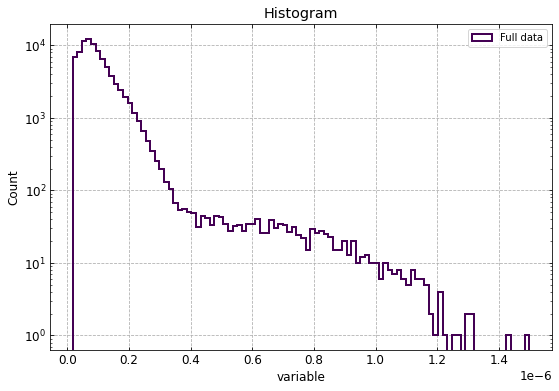

In [272]:
#check the distribution of amplitudes
fig, ax = dp.hist(
    df.ofamp_nodelay_CPDv21Ge[cmask],
    nbins=100,
    #xlims=
)